## Graph API (Must before going below)
https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs 

### Class StateGraph ¶
Bases: Generic[StateT, ContextT, InputT, OutputT]

A graph whose nodes communicate by reading and writing to a shared state. The signature of each node is State -> Partial.

Each state key can optionally be annotated with a reducer function that will be used to aggregate the values of that key received from multiple nodes. The signature of a reducer function is (Value, Value) -> Value.



In [5]:
from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated, TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph
from langgraph.runtime import Runtime

def reducer(a: list, b: int | None) -> list:
    if b is not None:
        return a + [b]
    return a

class State(TypedDict):
    x: Annotated[list, reducer]

class Context(TypedDict):
    r: float

graph = StateGraph(state_schema=State, context_schema=Context)

def node(state: State, runtime: Runtime[Context]) -> dict:
    r = runtime.context.get("r", 1.0)
    x = state["x"][-1]
    next_value = x * r * (1 - x)
    return {"x": next_value}

graph.add_node("A", node)
graph.set_entry_point("A")
graph.set_finish_point("A")
compiled = graph.compile()

step1 = compiled.invoke({"x": 0.5}, context={"r": 3.0})
# {'x': [0.5, 0.75]}
step1

{'x': [0.5, 0.75]}

#### Some explanations:
1. Runtime: Gives you access to things like context while the graph is running.

2. graph = StateGraph(state_schema=State, context_schema=Context)

   state_schema defines what’s passed between nodes (State).

context_schema defines what’s available from runtime.context.

#### What’s special here
This graph remembers past outputs in x because of the reducer.



In [8]:
last_value = step1["x"][-1]
step2 = compiled.invoke({"x": last_value}, context={"r": 3.0})
step2

{'x': [0.75, 0.5625]}

#### Methods

| Method                 | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| add_node               | Add a new node to the state graph.                                          |
| add_edge               | Add a directed edge from the start node (or list of start nodes) to the end node. |
| add_conditional_edges  | Add a conditional edge from the starting node to any number of destination nodes. |
| add_sequence           | Add a sequence of nodes that will be executed in the provided order.        |
| compile                | Compiles the state graph into a CompiledStateGraph object.                  |


#### Method- add_node

In [12]:
from typing_extensions import TypedDict

from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, StateGraph

class State(TypedDict):
    x: int

def my_node(state: State, config: RunnableConfig) -> State:
    return {"x": state["x"] + 1}

builder = StateGraph(State)
builder.add_node(my_node)  # node name will be 'my_node'
builder.add_edge(START, "my_node")
graph = builder.compile()





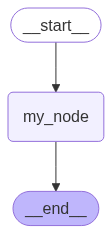

In [13]:
from utils import show_graph
show_graph(graph)


In [14]:
graph.invoke({"x": 1})

{'x': 2}

##### Customize the name

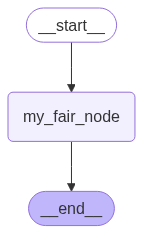

In [15]:
builder = StateGraph(State)
builder.add_node("my_fair_node", my_node)
builder.add_edge(START, "my_fair_node")
graph = builder.compile()
show_graph(graph)


#### Method- add_edge

#### add_edge(start_key: str | list[str], end_key: str) -> Self
Add a directed edge from the start node (or list of start nodes) to the end node.

When a single start node is provided, the graph will wait for that node to complete before executing the end node. When multiple start nodes are provided, the graph will wait for ALL of the start nodes to complete before executing the end node.

Parameters:

| Name       | Type                | Description                                      | Default   |
|------------|---------------------|--------------------------------------------------|-----------|
| start_key  | str \| list[str]     | The key(s) of the start node(s) of the edge.     | required  |
| end_key    | str                  | The key of the end node of the edge.             | required  |

**Raises**

| Type        | Description                                                                 |
|-------------|-----------------------------------------------------------------------------|
| ValueError  | If the start key is 'END' or if the start key or end key is not present in the graph. |

**Returns**

| Name  | Type  | Description                                                              |
|-------|-------|--------------------------------------------------------------------------|
| Self  | Self  | The instance of the state graph, allowing for method chaining.           |


### More :
#### 1. conditional_edge :

graph.add_conditional_edges(

    start_key="start_node_name",   # Node where branching begins

    condition=condition_function, # Function that decides next node(s)
)

for example : 

def condition_function(state) -> str | list[str]:
    """
    Decide the next node(s) based on the current graph state.

    Parameters:
        state (dict): The current state of the graph.

    Returns:

        str        → name of the next node (single path)

        list[str]  → names of next nodes (parallel paths)
    """
    # Example: simple routing logic
    if some_condition:
        return "next_node_1"
    elif other_condition:
        return "next_node_2"
    else:
        return "default_node"




-----------------------------------

2. graph compile

3. compiled graph state

LInk: https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages

#### 4.  with_config
with_config(

    config: RunnableConfig | None = None, **kwargs: Any

) -> Self

link : https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.CompiledStateGraph.with_config

#### 5. add_messages

add_messages(

    left: Messages,

    right: Messages,

    *,

    format: Literal["langchain-openai"] | None = None

) -> Messages

---> Merges two lists of messages, updating existing messages by ID.

By default, this ensures the state is "append-only", unless the new message has the same ID as an existing message.

link : https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages 

In [18]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages
msgs1 = [HumanMessage(content="Hello", id="1")]
msgs2 = [AIMessage(content="Hi there!", id="2")]
add_messages(msgs1, msgs2)


## output
# [HumanMessage(content='Hello', id='1'), AIMessage(content='Hi there!', id='2')]

[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='2')]

##### Overwrite existing message

In [19]:


msgs1 = [HumanMessage(content="Hello", id="1")]
msgs2 = [HumanMessage(content="Hello again", id="1")]
add_messages(msgs1, msgs2)
# [HumanMessage(content='Hello again', id='1')]

[HumanMessage(content='Hello again', additional_kwargs={}, response_metadata={}, id='1')]

#### an example

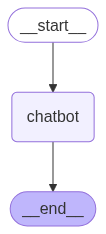

In [20]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(State)
builder.add_node("chatbot", lambda state: {"messages": [("assistant", "Hello")]})
builder.set_entry_point("chatbot")
builder.set_finish_point("chatbot")
graph = builder.compile()

# {'messages': [AIMessage(content='Hello', id=...)]}
show_graph(graph)

In [21]:
graph.invoke({})

{'messages': [AIMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='5f464cbf-636f-4690-84b0-42a234e8ebf5')]}

#### Use OpenAI message format

In [22]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages(format='langchain-openai')]

def chatbot_node(state: State) -> list:
    return {"messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Here's an image:",
                    "cache_control": {"type": "ephemeral"},
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": "1234",
                    },
                },
            ]
        },
    ]}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot_node)
builder.set_entry_point("chatbot")
builder.set_finish_point("chatbot")
graph = builder.compile()
graph.invoke({"messages": []})
# {
#     'messages': [
#         HumanMessage(
#             content=[
#                 {"type": "text", "text": "Here's an image:"},
#                 {
#                     "type": "image_url",
#                     "image_url": {"url": "data:image/jpeg;base64,1234"},
#                 },
#             ],
#         ),
#     ]
# }

{'messages': [HumanMessage(content=[{'type': 'text', 'text': "Here's an image:"}, {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,1234'}}], additional_kwargs={}, response_metadata={})]}

### Creating a basic chatbot

#### 1. creating stategraph

In [23]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

##### Explanation :
Our graph can now handle two key tasks:

1. Each node can receive the current State as input and output an update to the state.

2. Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt reducer function.

Note : When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions(https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) that handle state updates. In our example, State is a schema with one key: messages. The reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values.

#### 2. Add a node¶

In [ ]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

In [25]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

#### Notice:
 how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the LLM's response messages to whatever messages are already in the state.

#### 3. Add an entry and exit point¶
Add an entry point to tell the graph where to start its work each time it is run.

Add an exit point to indicate where the graph should finish execution. This is helpful for more complex flows, but even in a simple graph like this, adding an end node improves clarity.

In [26]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

#### 4. Compile and visulaize the graph

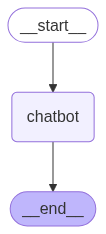

In [27]:
graph = graph_builder.compile()


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### 5. Run the chatbot

In [28]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today?
Assistant: Today’s date is June 12, 2024.
Assistant: It looks like you mentioned "my first question was" but didn't include your original question. Could you please specify what your first question was, or ask it again? I'm here to help!
Assistant: Hello! It looks like you typed "hupp." Did you mean something else or need help with a question or topic? Let me know how I can assist you! 😊
Assistant: It looks like you typed "i loev i." Did you mean "I love you"?  
If so, that's very sweet! 🥰

Or if you meant something else, could you clarify what you wanted to say?
Goodbye!


### Now add some tools 

#### deifining serach tool

In [ ]:
# pip install -U langchain-tavily

In [ ]:
import os



In [32]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making b

#### Define the graph with tool
For the StateGraph you created in the first tutorial, add bind_tools on the LLM. This lets the LLM know the correct JSON format to use if it wants to use the search engine.

In [38]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

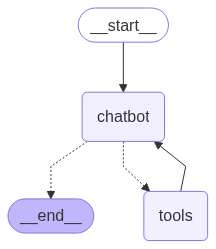

In [36]:
show_graph(graph)

In [39]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today?
Assistant: 
Assistant: {"query": "Gurugram weather forecast tonight", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Gurugram, India", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'La India (La India Calosa)', 'region': 'Guerrero', 'country': 'Mexico', 'lat': 16.587, 'lon': -98.6336, 'tz_id': 'America/Mexico_City', 'localtime_epoch': 1755072489, 'localtime': '2025-08-13 02:08'}, 'current': {'last_updated_epoch': 1755072000, 'last_updated': '2025-08-13 02:00', 'temp_c': 25.3, 'temp_f': 77.6, 'is_day': 0, 'condition': {'text': 'Light rain shower', 'icon': '//cdn.weatherapi.com/weather/64x64/night/353.png', 'code': 1240}, 'wind_mph': 2.9, 'wind_kph': 4.7, 'wind_degree': 131, 'wind_dir': 'SE', 'pressure_mb': 1013.0, 'pressure_in': 29.91, 'precip_mm': 0.22, 'precip_in': 0.01, 'humidity': 88, 'cloud': 54, 'feelslike_c': 28.1, 'feelslike_f': 82.6, 'windchill_c': 25.3, 'windchil

### NOte : There is more concepts such as :

1. Add memory : https://langchain-ai.github.io/langgraph/tutorials/get-started/3-add-memory/ 
2. Add human in the loop : https://langchain-ai.github.io/langgraph/tutorials/get-started/4-human-in-the-loop/ 
3. Customize State: https://langchain-ai.github.io/langgraph/tutorials/get-started/5-customize-state/

### Workflows and Agents

Workflows are systems where LLMs and tools are orchestrated through predefined code paths. Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Here is a simple way to visualize these differences:

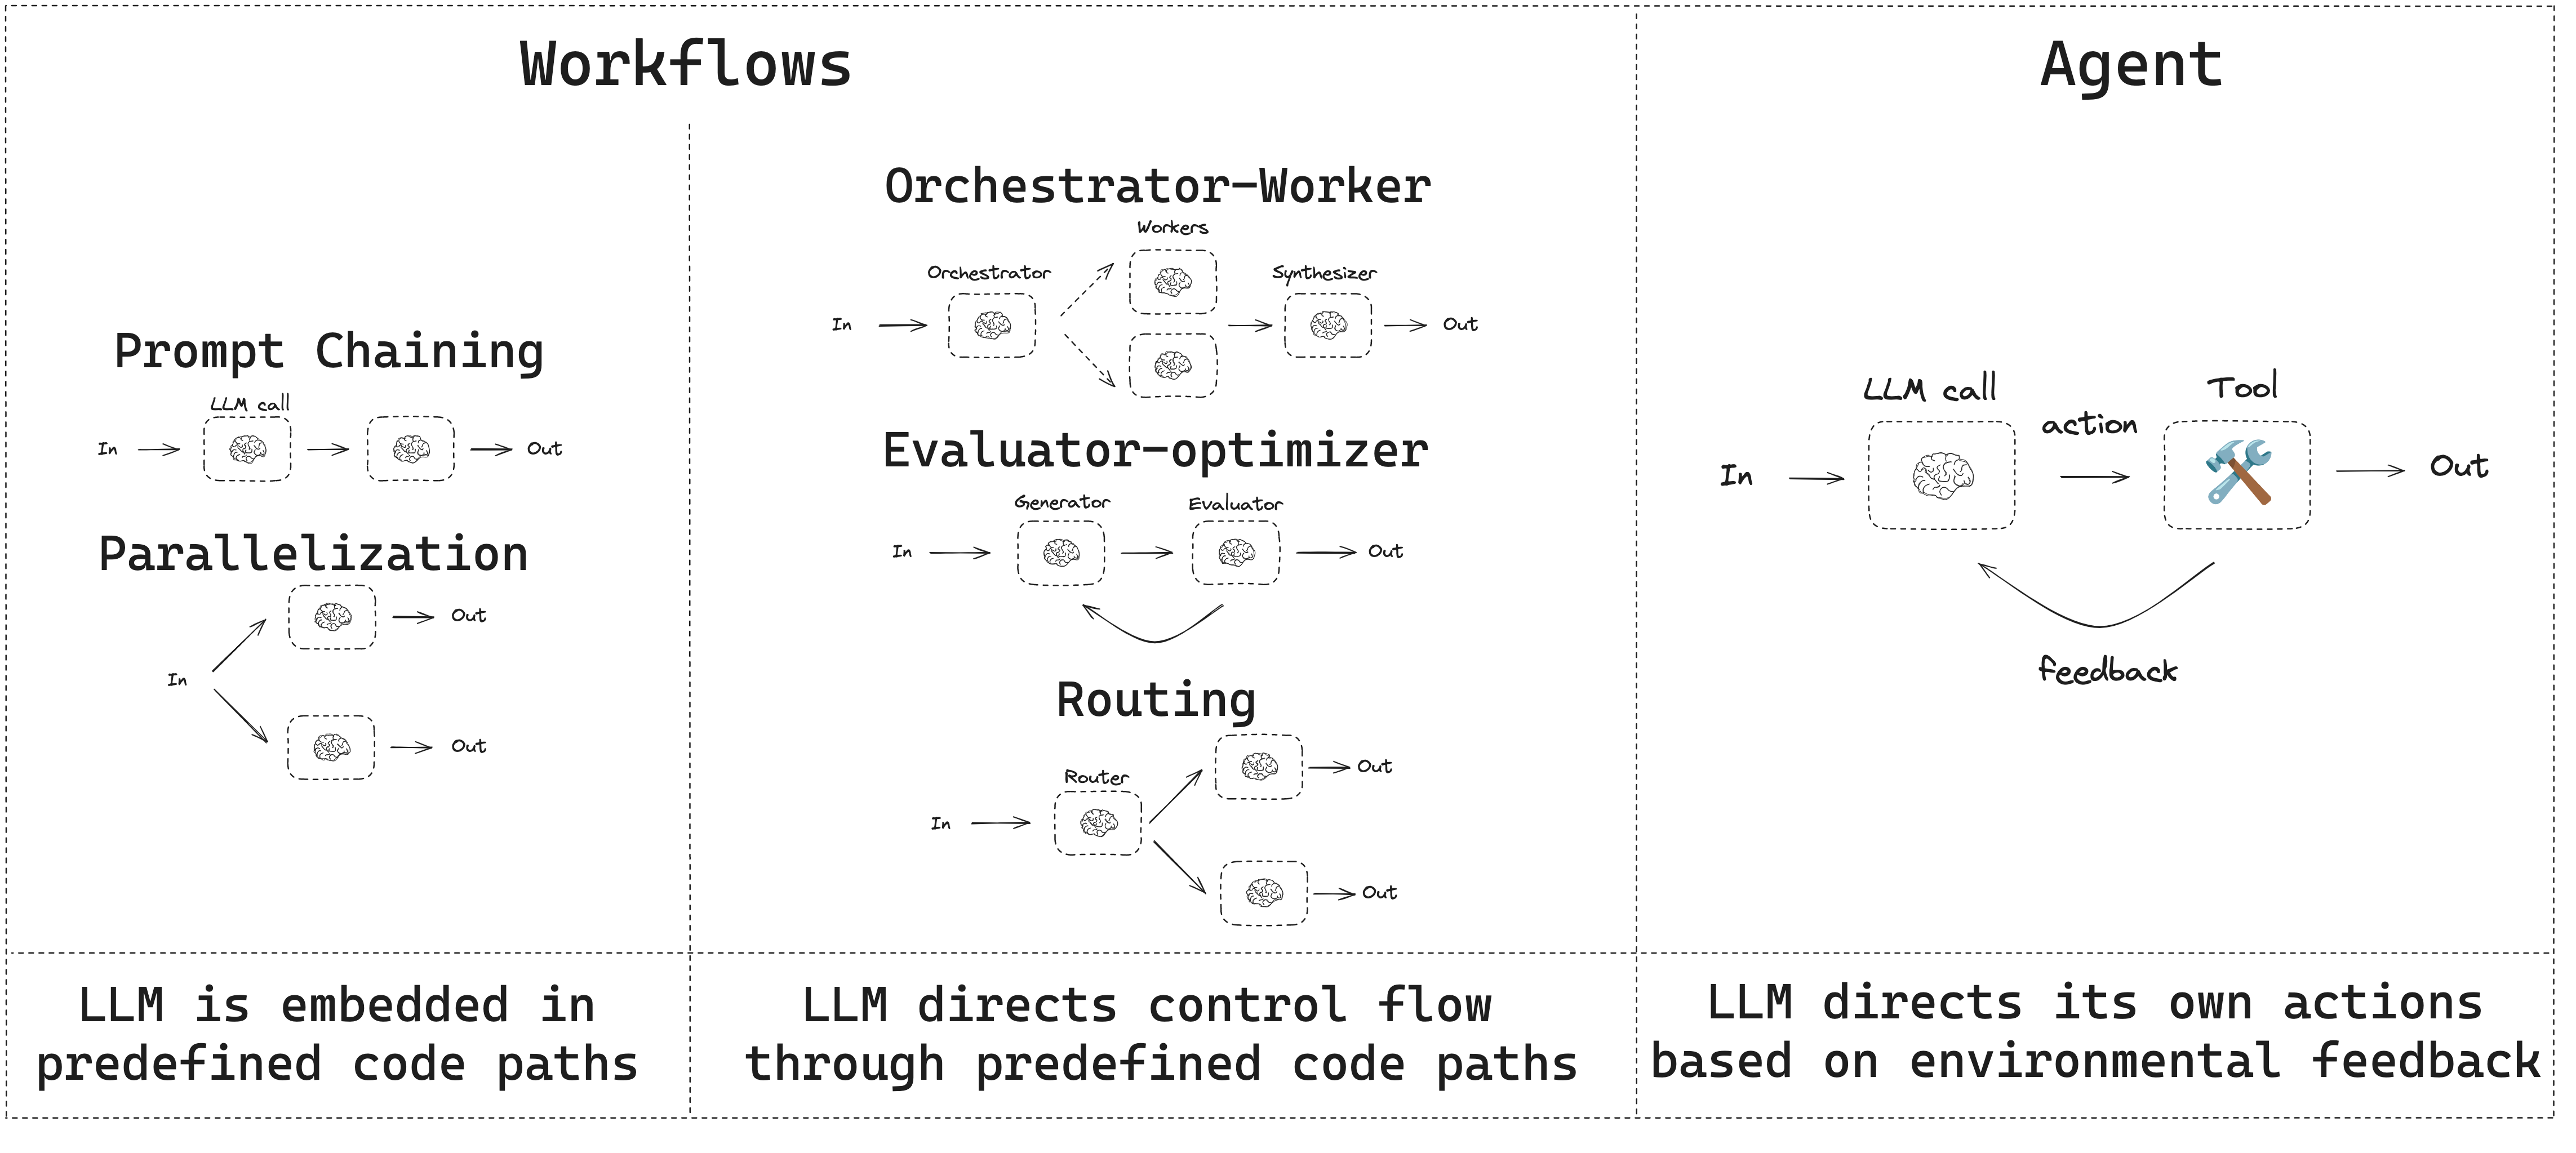
Agent Workflow

#### 10th MAth teacher

In [ ]:
import os
from typing import TypedDict, Annotated, Dict, Any, List
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.tools import tool
import operator
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy import symbols, solve, expand, factor, diff, integrate
import json


# Define the state structure
class MathTeacherState(TypedDict):
    messages: Annotated[List[dict], operator.add]
    current_topic: str
    student_level: str
    explanation_needed: bool
    problem_solved: bool
    work_shown: bool

# Define mathematical tools for 10th grade curriculum
@tool
def solve_quadratic_equation(a: float, b: float, c: float) -> dict:
    """
    Solve quadratic equations of the form ax² + bx + c = 0
    Returns the solutions and discriminant information
    """
    discriminant = b**2 - 4*a*c
    
    if discriminant > 0:
        root1 = (-b + math.sqrt(discriminant)) / (2*a)
        root2 = (-b - math.sqrt(discriminant)) / (2*a)
        return {
            "solutions": [root1, root2],
            "discriminant": discriminant,
            "nature": "Two real and distinct roots"
        }
    elif discriminant == 0:
        root = -b / (2*a)
        return {
            "solutions": [root],
            "discriminant": discriminant,
            "nature": "One real root (repeated)"
        }
    else:
        real_part = -b / (2*a)
        imaginary_part = math.sqrt(abs(discriminant)) / (2*a)
        return {
            "solutions": [f"{real_part} + {imaginary_part}i", f"{real_part} - {imaginary_part}i"],
            "discriminant": discriminant,
            "nature": "Two complex roots"
        }

@tool
def calculate_trigonometric_values(angle: float, function: str, unit: str = "degrees") -> dict:
    """
    Calculate trigonometric values (sin, cos, tan, cot, sec, cosec)
    angle: angle value
    function: sin, cos, tan, cot, sec, cosec
    unit: degrees or radians
    """
    if unit == "degrees":
        angle_rad = math.radians(angle)
    else:
        angle_rad = angle
    
    functions = {
        "sin": math.sin(angle_rad),
        "cos": math.cos(angle_rad),
        "tan": math.tan(angle_rad) if math.cos(angle_rad) != 0 else "undefined",
        "cot": 1/math.tan(angle_rad) if math.sin(angle_rad) != 0 else "undefined",
        "sec": 1/math.cos(angle_rad) if math.cos(angle_rad) != 0 else "undefined",
        "cosec": 1/math.sin(angle_rad) if math.sin(angle_rad) != 0 else "undefined"
    }
    
    return {
        "angle": angle,
        "unit": unit,
        "function": function,
        "value": functions.get(function, "Invalid function"),
        "all_values": functions
    }

@tool
def solve_arithmetic_progression(first_term: float, common_difference: float, n: int = None, nth_term: float = None) -> dict:
    """
    Solve Arithmetic Progression problems
    Can find nth term, sum of n terms, or number of terms
    """
    if n is not None:
        nth_term_calc = first_term + (n - 1) * common_difference
        sum_n_terms = n * (2 * first_term + (n - 1) * common_difference) / 2
        return {
            "first_term": first_term,
            "common_difference": common_difference,
            "n": n,
            "nth_term": nth_term_calc,
            "sum_of_n_terms": sum_n_terms
        }
    elif nth_term is not None:
        n_calc = ((nth_term - first_term) / common_difference) + 1
        return {
            "first_term": first_term,
            "common_difference": common_difference,
            "nth_term": nth_term,
            "n": n_calc
        }

@tool
def solve_geometry_problems(shape: str, **kwargs) -> dict:
    """
    Solve various geometry problems for 10th grade
    Supports: circle, triangle, rectangle, square
    """
    if shape == "circle":
        if "radius" in kwargs:
            r = kwargs["radius"]
            return {
                "shape": "circle",
                "radius": r,
                "diameter": 2 * r,
                "circumference": 2 * math.pi * r,
                "area": math.pi * r**2
            }
        elif "diameter" in kwargs:
            d = kwargs["diameter"]
            r = d / 2
            return {
                "shape": "circle",
                "diameter": d,
                "radius": r,
                "circumference": math.pi * d,
                "area": math.pi * r**2
            }
    
    elif shape == "triangle":
        if "base" in kwargs and "height" in kwargs:
            base = kwargs["base"]
            height = kwargs["height"]
            return {
                "shape": "triangle",
                "base": base,
                "height": height,
                "area": 0.5 * base * height
            }
        elif "a" in kwargs and "b" in kwargs and "c" in kwargs:
            a, b, c = kwargs["a"], kwargs["b"], kwargs["c"]
            s = (a + b + c) / 2
            area = math.sqrt(s * (s - a) * (s - b) * (s - c))
            return {
                "shape": "triangle",
                "sides": [a, b, c],
                "perimeter": a + b + c,
                "area": area
            }
    
    return {"error": "Invalid shape or insufficient parameters"}

@tool
def calculate_statistics(data: List[float]) -> dict:
    """
    Calculate basic statistics for 10th grade: mean, median, mode, range, variance, standard deviation
    """
    n = len(data)
    mean = sum(data) / n
    
    sorted_data = sorted(data)
    if n % 2 == 0:
        median = (sorted_data[n//2 - 1] + sorted_data[n//2]) / 2
    else:
        median = sorted_data[n//2]
    
    # Mode calculation
    from collections import Counter
    count = Counter(data)
    max_count = max(count.values())
    mode = [k for k, v in count.items() if v == max_count]
    
    # Range
    range_val = max(data) - min(data)
    
    # Variance and Standard Deviation
    variance = sum((x - mean)**2 for x in data) / n
    std_dev = math.sqrt(variance)
    
    return {
        "data": data,
        "count": n,
        "mean": mean,
        "median": median,
        "mode": mode,
        "range": range_val,
        "variance": variance,
        "standard_deviation": std_dev
    }

@tool
def factor_polynomial(expression: str) -> dict:
    """
    Factor polynomial expressions using sympy
    """
    try:
        x = symbols('x')
        expr = sp.sympify(expression)
        factored = factor(expr)
        expanded = expand(expr)
        
        return {
            "original": str(expr),
            "factored": str(factored),
            "expanded": str(expanded)
        }
    except Exception as e:
        return {"error": f"Could not factor expression: {str(e)}"}

# Define the nodes for our graph
def math_teacher_node(state: MathTeacherState) -> Dict[str, Any]:
    """
    Main teaching node that provides mathematical instruction and problem solving
    """
    system_message = """You are an expert 10th-grade mathematics teacher. Your role is to:

    1. **Teach mathematical concepts clearly** - Explain topics like algebra, geometry, trigonometry, coordinate geometry, statistics, and arithmetic progressions
    2. **Solve problems step-by-step** - Show complete working for all problems
    3. **Provide examples** - Give relevant examples to illustrate concepts
    4. **Check understanding** - Ask questions to ensure student comprehension
    5. **Use appropriate tools** - Utilize the mathematical tools available for calculations

    **10th Grade Math Topics You Cover:**
    - Quadratic equations and polynomials
    - Arithmetic and geometric progressions
    - Coordinate geometry
    - Trigonometry (basic ratios, identities)
    - Circles and their properties
    - Areas and volumes
    - Statistics (mean, median, mode)
    - Probability basics

    Always:
    - Show step-by-step solutions
    - Explain the reasoning behind each step
    - Provide multiple approaches when possible
    - Use simple language appropriate for 10th graders
    - Encourage questions and practice

    You have access to specialized mathematical tools. Use them when needed for calculations and verification.
    """
    
    messages = [SystemMessage(content=system_message)] + state["messages"]
    
    model = ChatOpenAI(model="gpt-4", temperature=0.1)
    tools = [
        solve_quadratic_equation,
        calculate_trigonometric_values,
        solve_arithmetic_progression,
        solve_geometry_problems,
        calculate_statistics,
        factor_polynomial
    ]
    
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    
    return {
        "messages": [response],
        "explanation_needed": True,
        "work_shown": True
    }

def tool_node(state: MathTeacherState) -> Dict[str, Any]:
    """
    Execute mathematical tools
    """
    tools = [
        solve_quadratic_equation,
        calculate_trigonometric_values,
        solve_arithmetic_progression,
        solve_geometry_problems,
        calculate_statistics,
        factor_polynomial
    ]
    
    tool_executor = ToolNode(tools)
    return tool_executor.invoke(state)

def should_continue(state: MathTeacherState) -> str:
    """
    Determine if we should continue with tool execution or end
    """
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return END

# Create the graph
def create_math_teacher_graph():
    """
    Create and return the LangGraph state graph for the math teacher
    """
    # Initialize the StateGraph
    workflow = StateGraph(MathTeacherState)
    
    # Add nodes
    workflow.add_node("math_teacher", math_teacher_node)
    workflow.add_node("tools", tool_node)
    
    # Add edges
    workflow.set_entry_point("math_teacher")
    workflow.add_conditional_edges(
        "math_teacher",
        should_continue,
        {
            "tools": "tools",
            END: END
        }
    )
    workflow.add_edge("tools", "math_teacher")
    
    return workflow.compile()

# Example usage and testing
def run_math_teacher():
    """
    Run the math teacher agent with example interactions
    """
    # Create the graph
    app = create_math_teacher_graph()
    
    # Example conversations
    examples = [
        "Can you help me solve the quadratic equation 2x² + 5x - 3 = 0?",
        "Explain what is an arithmetic progression and solve: Find the 10th term of AP where first term is 5 and common difference is 3",
        "Calculate sin(30°), cos(45°), and tan(60°)",
        "Find the area and circumference of a circle with radius 7 cm",
        "Factor the polynomial x² + 5x + 6",
        "Calculate the mean, median, and mode of the data: [85, 90, 78, 92, 88, 85, 95, 87]"
    ]
    
    print("🎓 Welcome to the 10th Grade Math Teacher Agent!")
    print("=" * 50)
    
    for i, question in enumerate(examples, 1):
        print(f"\n📚 Example {i}: {question}")
        print("-" * 50)
        
        # Initialize state
        initial_state = {
            "messages": [HumanMessage(content=question)],
            "current_topic": "general",
            "student_level": "10th_grade",
            "explanation_needed": True,
            "problem_solved": False,
            "work_shown": False
        }
        
        # Run the graph
        result = app.invoke(initial_state)
        
        # Print the response
        for message in result["messages"]:
            if hasattr(message, 'content') and message.content:
                print("🤖 Teacher:", message.content)
        
        print("\n" + "="*50)

# Interactive mode
def interactive_math_teacher():
    """
    Run the math teacher in interactive mode
    """
    app = create_math_teacher_graph()
    
    print("🎓 Welcome to your Personal 10th Grade Math Teacher!")
    print("Ask me any math question or type 'quit' to exit.")
    print("="*50)
    
    while True:
        user_input = input("\n🧑‍🎓 Student: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("👋 Goodbye! Keep practicing math!")
            break
        
        if not user_input:
            continue
        
        # Initialize state
        initial_state = {
            "messages": [HumanMessage(content=user_input)],
            "current_topic": "general",
            "student_level": "10th_grade",
            "explanation_needed": True,
            "problem_solved": False,
            "work_shown": False
        }
        
        try:
            # Run the graph
            result = app.invoke(initial_state)
            
            # Print the response
            for message in result["messages"]:
                if hasattr(message, 'content') and message.content:
                    print(f"\n🤖 Teacher: {message.content}")
        
        except Exception as e:
            print(f"❌ Sorry, I encountered an error: {str(e)}")
            print("Please try rephrasing your question.")

# Additional utility functions
def get_curriculum_topics():
    """
    Return the 10th grade math curriculum topics covered by this agent
    """
    return {
        "Algebra": [
            "Quadratic equations",
            "Polynomial operations",
            "Factoring",
            "Systems of equations"
        ],
        "Geometry": [
            "Circles and their properties",
            "Areas and perimeters",
            "Coordinate geometry",
            "Triangles and quadrilaterals"
        ],
        "Trigonometry": [
            "Basic trigonometric ratios",
            "Trigonometric identities",
            "Heights and distances",
            "Angle measurement"
        ],
        "Statistics": [
            "Measures of central tendency",
            "Data organization",
            "Probability basics",
            "Graphical representation"
        ],
        "Number Systems": [
            "Arithmetic progressions",
            "Geometric progressions",
            "Real numbers",
            "Rational and irrational numbers"
        ]
    }

if __name__ == "__main__":
    # You can choose to run examples or interactive mode
    print("Choose mode:")
    print("1. Run example problems")
    print("2. Interactive mode")
    
    choice = input("Enter choice (1 or 2): ").strip()
    
    if choice == "1":
        run_math_teacher()
    else:
        interactive_math_teacher()


Choose mode:
1. Run example problems
2. Interactive mode
🎓 Welcome to your Personal 10th Grade Math Teacher!
Ask me any math question or type 'quit' to exit.

🤖 Teacher: hi

🤖 Teacher: Hello! How can I assist you with your 10th-grade math today?

🤖 Teacher: tan 60 degree value

🤖 Teacher: {"angle": 60.0, "unit": "degrees", "function": "tan", "value": 1.7320508075688767, "all_values": {"sin": 0.8660254037844386, "cos": 0.5000000000000001, "tan": 1.7320508075688767, "cot": 0.577350269189626, "sec": 1.9999999999999996, "cosec": 1.1547005383792517}}

🤖 Teacher: The value of tan 60 degrees is approximately 1.732. 

Remember, in a right-angled triangle, the tangent of an angle is the ratio of the length of the opposite side to the length of the adjacent side. So, for an angle of 60 degrees, this ratio is 1.732.

🤖 Teacher: A vertical flagpole of height 6 m is fixed on the roof of a building. From a point  𝑃 P on level ground, the angles of elevation of the top of the flagpole and the top of 